# Object Detection with halfsqueezenet implemented in spooNN
This notebook shows how to perform object detection using the CNN implemented with spooNN.

## 1. Preparation

First we import all the necessary components:

In [1]:
import sys
import math
import numpy as np
import os
import time
from PIL import Image
from matplotlib import pyplot
import cv2
from datetime import datetime
from pynq import Xlnk
from pynq import Overlay
from pynq.mmio import MMIO
import scipy.misc
from IPython.display import display

Next, we get the overlay that is in the same directory as this notebook. This is loaded onto the FPGA fabric on the PYNQ. Then, a handle to the spooNN IP is obtained via nn_ctrl. Using this, we are able to write to the registers of the IP to configure it.

In [2]:
OVERLAY_PATH = 'halfsqueezenet_overlay.bit'
overlay = Overlay(OVERLAY_PATH)
dma = overlay.axi_dma_0
WEIGHTS_FILE_NAME = 'halfsqueezenet_weights_file.txt'

xlnk = Xlnk()
nn_ctrl = MMIO(0x43c00000, length=1024)
print('Got nn_ctrl!')

Got nn_ctrl!


Let's read some images, where we want to detect objects.

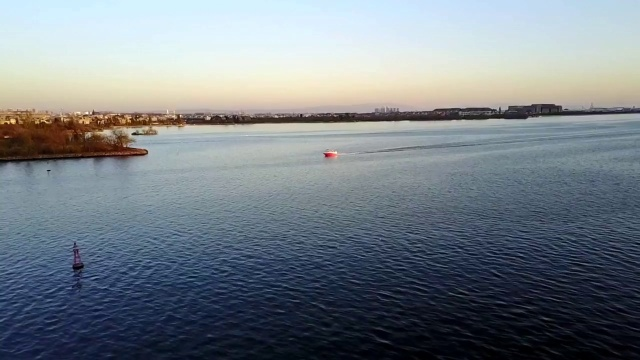

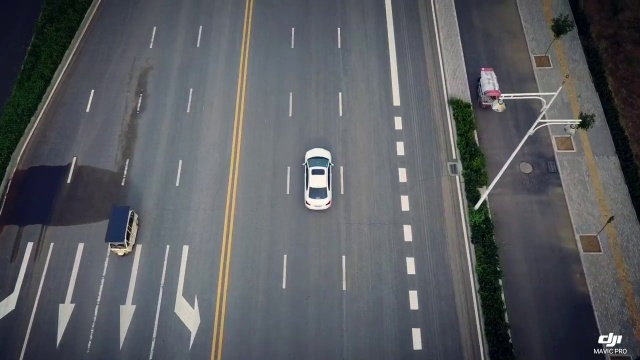

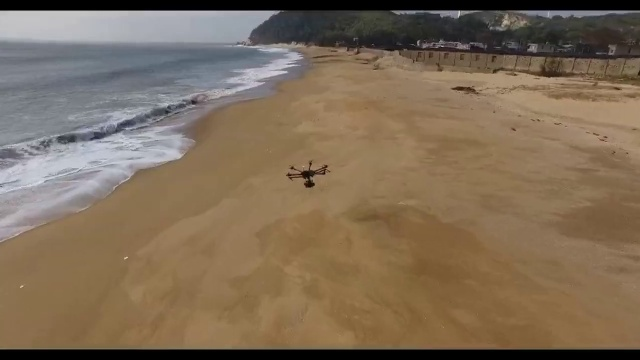

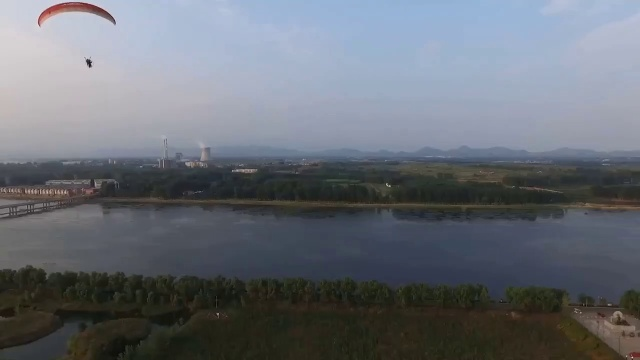

In [3]:
boat_im = cv2.imread('boat.jpg', cv2.IMREAD_COLOR)
boat_im_rgb = cv2.cvtColor(boat_im, cv2.COLOR_BGR2RGB)
display(scipy.misc.toimage( boat_im_rgb ))

car_im = cv2.imread('car.jpg', cv2.IMREAD_COLOR)
car_im_rgb = cv2.cvtColor(car_im, cv2.COLOR_BGR2RGB)
display(scipy.misc.toimage( car_im_rgb ))

drone_im = cv2.imread('drone.jpg', cv2.IMREAD_COLOR)
drone_im_rgb = cv2.cvtColor(drone_im, cv2.COLOR_BGR2RGB)
display(scipy.misc.toimage( drone_im_rgb ))

paraglider_im = cv2.imread('paraglider.jpg', cv2.IMREAD_COLOR)
paraglider_im_rgb = cv2.cvtColor(paraglider_im, cv2.COLOR_BGR2RGB)
display(scipy.misc.toimage( paraglider_im_rgb ))

im_list = [boat_im, car_im, drone_im, paraglider_im]

## 2. Buffer allocation and loading weights to the memory

Here, we allocate the necessary buffers for intermediate data storage. We also read the CNN weights from the text file and store them in numpy arrays.

In [4]:
## Allocate Buffers
MINIBATCH_SIZE = 4
height = 224
width = 224
pixel_bits = 24
pixels_per_line = 384/pixel_bits
num_lines = int((height*width)/pixels_per_line)

in_buffer = xlnk.cma_array(shape=(MINIBATCH_SIZE*num_lines, 64), dtype=np.uint8)

fire1_num_out_lines = 28*28*MINIBATCH_SIZE
fire1_out_buffer = xlnk.cma_array(shape=(int(16*fire1_num_out_lines),), dtype=np.uint32)
fire2345_num_out_lines = 14*14*MINIBATCH_SIZE
fire2_out_buffer = xlnk.cma_array(shape=(int(16*fire2345_num_out_lines),), dtype=np.uint32)
fire3_out_buffer = xlnk.cma_array(shape=(int(16*fire2345_num_out_lines),), dtype=np.uint32)
bndboxes = xlnk.cma_array(shape=(int(MINIBATCH_SIZE),16), dtype=np.int32)

In [5]:
## Allocate SW weight buffers and load from text file
weights_file = open(WEIGHTS_FILE_NAME, "r")
layer = 0
squeeze_weight_iterations = np.zeros(7)
expand_weight_iterations = np.zeros(7)
squeeze_factor_iterations = np.zeros(7)
expand_factor_iterations = np.zeros(7)
for line in weights_file:
    if "layer" in line:
        temp = line.split(": ")
        layer = int(temp[1])
    if "squeeze_weight_iterations" in line:
        temp = line.split(": ")
        squeeze_weight_iterations[layer] = int(temp[1])
    if "expand_weight_iterations" in line:
        temp = line.split(": ")
        expand_weight_iterations[layer] = int(temp[1])
    if "squeeze_factor_iterations" in line:
        temp = line.split(": ")
        squeeze_factor_iterations[layer] = int(temp[1])
    if "expand_factor_iterations" in line:
        temp = line.split(": ")
        expand_factor_iterations[layer] = int(temp[1])
weights_file.close()
weightfactors_length = np.zeros(7)
for i in range(0, 7):
    weightfactors_length[i] = int(squeeze_weight_iterations[i] + \
                                expand_weight_iterations[i] + \
                                squeeze_factor_iterations[i] + \
                                expand_factor_iterations[i])
weightsfactors = []
weightsfactors.append( xlnk.cma_array(shape=(int(16*weightfactors_length[0]),), dtype=np.uint32) )
weightsfactors.append( xlnk.cma_array(shape=(int(16*weightfactors_length[1]),), dtype=np.uint32) )
weightsfactors.append( xlnk.cma_array(shape=(int(16*weightfactors_length[2]),), dtype=np.uint32) )
weightsfactors.append( xlnk.cma_array(shape=(int(16*weightfactors_length[3]),), dtype=np.uint32) )
weightsfactors.append( xlnk.cma_array(shape=(int(16*weightfactors_length[4]),), dtype=np.uint32) )
weightsfactors.append( xlnk.cma_array(shape=(int(16*weightfactors_length[5]),), dtype=np.uint32) )
weightsfactors.append( xlnk.cma_array(shape=(int(16*weightfactors_length[6]),), dtype=np.uint32) )
index = 0
weights_file = open(WEIGHTS_FILE_NAME, "r")
for line in weights_file:
    if "layer" in line:
        temp = line.split(": ")
        layer = int(temp[1])
        index = 0
    elif "squeeze_weight_iterations" not in line and \
            "expand_weight_iterations" not in line and \
            "squeeze_factor_iterations" not in line and \
            "expand_factor_iterations" not in line:
        no0x = line.split('0x')[-1]
        base = 1
        while base < len(no0x):
            part = no0x[-1*(base+8):-1*base]    
            weightsfactors[layer][index*16 + int(base/8)] = int(part, 16)
            base += 8
        index += 1

The following two functions are helper functions for initiating the CNN on the FPGA. One is for transferring the weights that are in the main memory of the CPU to FPGA-local memory (BRAM). The other one configures the dataflow in the FPGA design and initiates the DMA transfer to execute a part of the CNN. 

In [6]:
## Define transfer functions
def weightsfactors_transfer(weightsfactors):
    nn_ctrl.write(0x68, 13)
    nn_ctrl.write(0x70, 0)
    nn_ctrl.write(0x0, 0) # Reset
    nn_ctrl.write(0x0, 1) # Deassert reset
    dma.sendchannel.transfer(weightsfactors)
    dma.sendchannel.wait()
    
def fire(inbuffer, outbuffer, 
         squeeze_din, squeeze_cin, squeeze_cout, 
         expand_din, expand_din_afterpool, expand_cin, expand_cout, 
         whichfire):
    nn_ctrl.write(0x0, 0) # Reset
    nn_ctrl.write(0x10, squeeze_din)
    nn_ctrl.write(0x18, squeeze_cin)
    nn_ctrl.write(0x20, squeeze_cout)
    nn_ctrl.write(0x28, 0)
    nn_ctrl.write(0x30, 0)
    nn_ctrl.write(0x38, expand_din)
    nn_ctrl.write(0x40, expand_din_afterpool)
    nn_ctrl.write(0x48, expand_cin)
    nn_ctrl.write(0x50, expand_cout)
    nn_ctrl.write(0x58, 0)
    nn_ctrl.write(0x60, 0)
    nn_ctrl.write(0x68, whichfire)
    nn_ctrl.write(0x70, MINIBATCH_SIZE) # set numReps
    nn_ctrl.write(0x0, 1) # Deassert reset
    dma.recvchannel.transfer(outbuffer)
    dma.sendchannel.transfer(inbuffer)

## 3. Execution
We are ready to perform inference on the images that we have loaded. The detection results are saved here.

In [7]:
## Inference (Main Part)
num_images = len(im_list)
result = xlnk.cma_array(shape=(int(num_images),5), dtype=np.int32)

for i in range(0,4):
    image = cv2.resize(im_list[i], (height, width))
    in_buffer[i*num_lines:(i+1)*num_lines,0:48] = np.reshape(image, (num_lines, 48))

weightsfactors_transfer(weightsfactors[0])
fire(in_buffer, fire1_out_buffer,
 56, 32, 32, 56, 28, 32, 96, 1)
dma.recvchannel.wait()

weightsfactors_transfer(weightsfactors[1])
fire(fire1_out_buffer, fire2_out_buffer,
 28, 96, 32, 28, 14, 32, 96, 2)
dma.recvchannel.wait()

weightsfactors_transfer(weightsfactors[2])
fire(fire2_out_buffer, fire3_out_buffer,
14, 96, 32, 14, 14, 32, 96, 3)
dma.recvchannel.wait()

weightsfactors_transfer(weightsfactors[3])
fire(fire3_out_buffer, fire2_out_buffer,
14, 96, 32, 14, 14, 32, 96, 4)
dma.recvchannel.wait()

weightsfactors_transfer(weightsfactors[4])
fire(fire2_out_buffer, fire3_out_buffer,
14, 96, 32, 14, 14, 32, 96, 5)
dma.recvchannel.wait()

weightsfactors_transfer(weightsfactors[5])
fire(fire3_out_buffer, fire2_out_buffer,
14, 96, 32, 14, 14, 32, 96, 6)
dma.recvchannel.wait()

weightsfactors_transfer(weightsfactors[6])
fire(fire2_out_buffer, bndboxes,
14, 96, 32, 14, 14, 32, 96, 7)
dma.recvchannel.wait()

result[:,:] = bndboxes[:,0:5]

Finally, we can display the results. We scale the bounding box values to match 640 by 360 images.

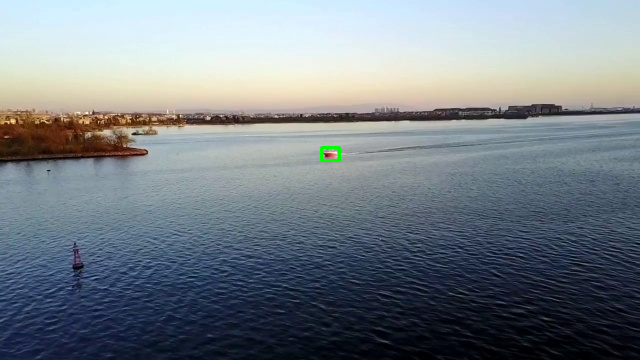

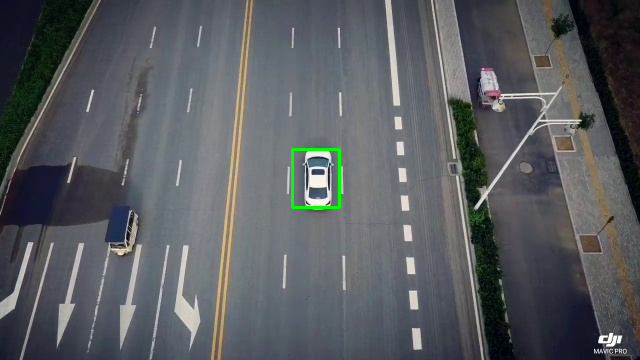

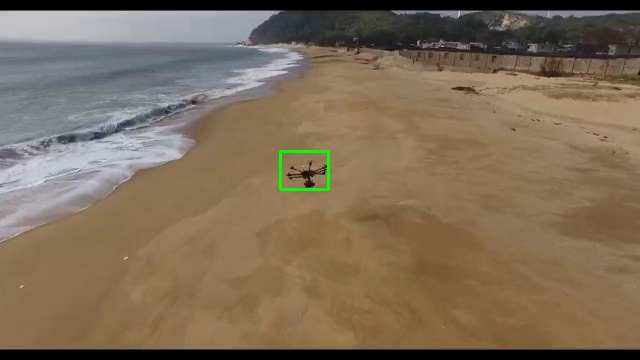

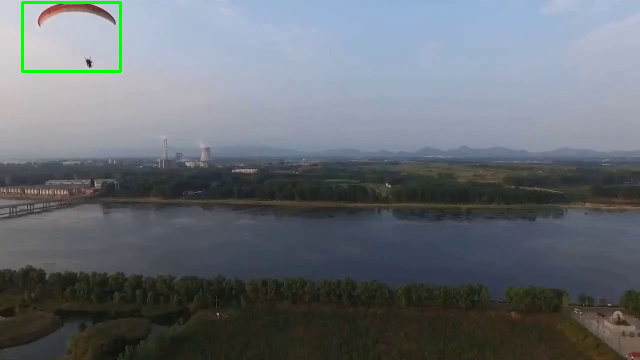

In [8]:
result_rectangles = []
for i in range(0,result.shape[0]):
    float_objdetect = result[i,4].astype('float')
    float_bndboxes = result[i,0:4].astype('float')
    float_bndboxes = np.divide( float_bndboxes, float((1<<22)) )
    float_bndboxes *= 0x882065
    float_bndboxes = np.divide( float_bndboxes, float((1<<22)) )
    
    obj_h = int(float_objdetect/14)
    obj_w = int(float_objdetect%14)
    x_min = int((float_bndboxes[0] + obj_w*16) *(640/width))
    y_min = int((float_bndboxes[1] + obj_h*16) *(360/height))
    x_max = int((float_bndboxes[2] + obj_w*16) *(640/width))
    y_max = int((float_bndboxes[3] + obj_h*16) *(360/height))
    
    result_rectangles.append([x_min, x_max, y_min, y_max])
    cv2.rectangle(im_list[i], (x_min, y_min), (x_max, y_max), (0,255,0), 2)
    display(scipy.misc.toimage( cv2.cvtColor(im_list[i], cv2.COLOR_BGR2RGB) ))